## Packages

In [1]:
# to speed-up execution, mark this as True
USE_CACHED_RESULTS=False
# cross-fold crashes Github CI
USE_CACHED_CV5_RESULTS = True

In [2]:
import maxent
import maxentep as py0
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyabc
import os
import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')

## Set-up SEAIR Model

In [3]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)

[4241. 3868. 1023.] [144101. 110004. 124468.]


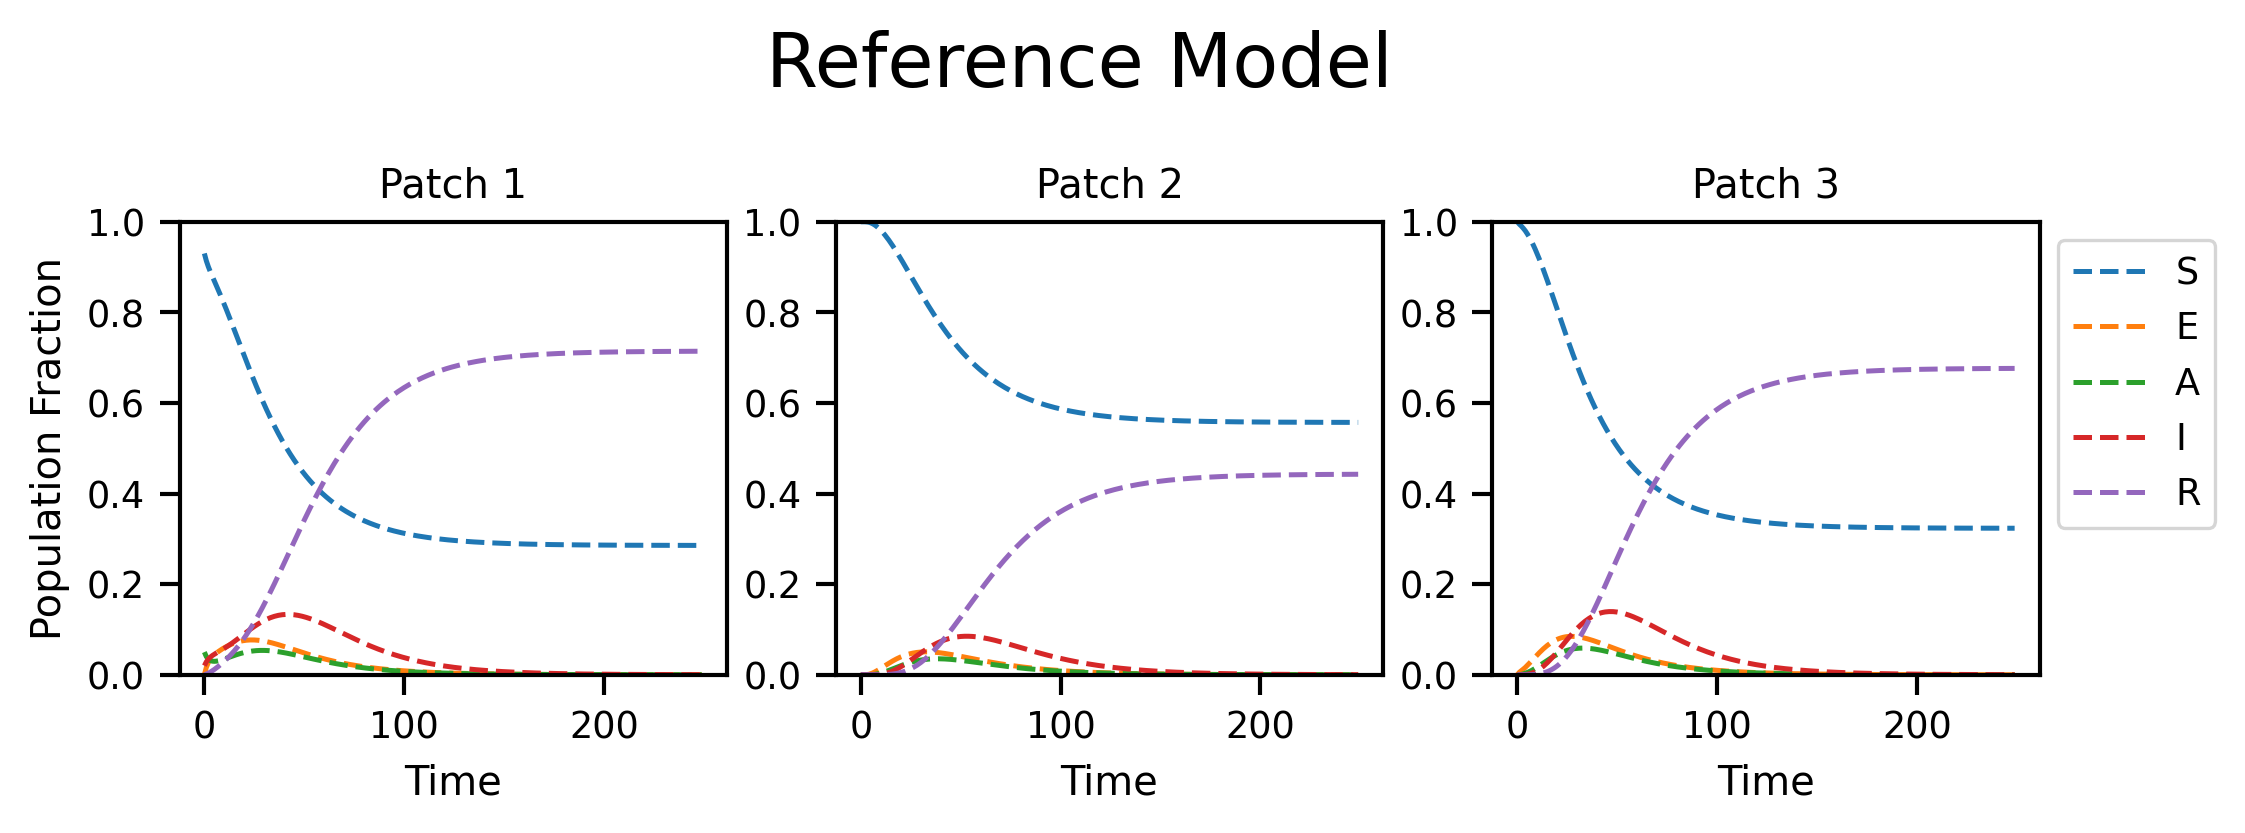

In [103]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
infect_fxn = py0.contact_infection_func(infections_compartments)
full_compartments = ['S'] + compartments
R = np.array([[1000, 400, 10],
         [0, 300, 300],
         [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    timesteps = 250
    meta_model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
ref_inpputs = [0.02, 0.05, 7, 5, 14]
ref_traj = metapop_wraper(*ref_inpputs )
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--', label=full_compartments)
axs[0].set_ylabel('Population Fraction')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [5]:
npoints = 5
np.random.seed(0)
prior = maxent.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300826 0.10784731813725082
45 0.13207552 0.1526054434665933
31 0.12169184 0.12889401646488136
80 0.06942835 0.1421420223992924
17 0.08018874 0.11824062257689161


## Sample SEAIR Trajectories

In [174]:
tf.random.set_seed(0)
if not USE_CACHED_RESULTS or not os.path.exists('epidemiology_files/maxent_sample_trajs'):
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1)
    tmat.add_transition('A', 'I', 2, 4)
    tmat.add_transition('I', 'R', 10, 5)
    start_logits = np.zeros((M))
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_var = 0.001
    hyper_pram.beta_start = 0.025
    hyper_pram.beta_high = 0.02502
    hyper_pram.beta_low = 0.02501
    hyper_pram.start_mean = 0.001
    hyper_pram.start_high = 0.4
    hyper_pram.start_var = 0.8
    hyper_pram.R_var = 0
    param_model = py0.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)
    # Fxing beta and mobility matrix
    R_norm_sample = tf.convert_to_tensor(R_norm)
    beta_sample = tf.convert_to_tensor([0.025])
    N = 2048
    batches = 4
    batch_size = N*batches
    outs = []
    timesteps = 250
    model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    for b in tqdm.tqdm(range(batches)):
        psample = param_model.sample(N)
        psample[0] = tf.repeat(R_norm_sample[tf.newaxis,:], len(psample[0]), axis =0) 
        psample[3] = tf.repeat(beta_sample[tf.newaxis,:], len(psample[0]), axis =0)
        outs.append(model(*psample))
    trajs = np.concatenate(outs, axis=0)
    np.save('epidemiology_files/maxent_sample_trajs', trajs)
else:
    trajs = np.load('epidemiology_files/maxent_sample_trajs.npy')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


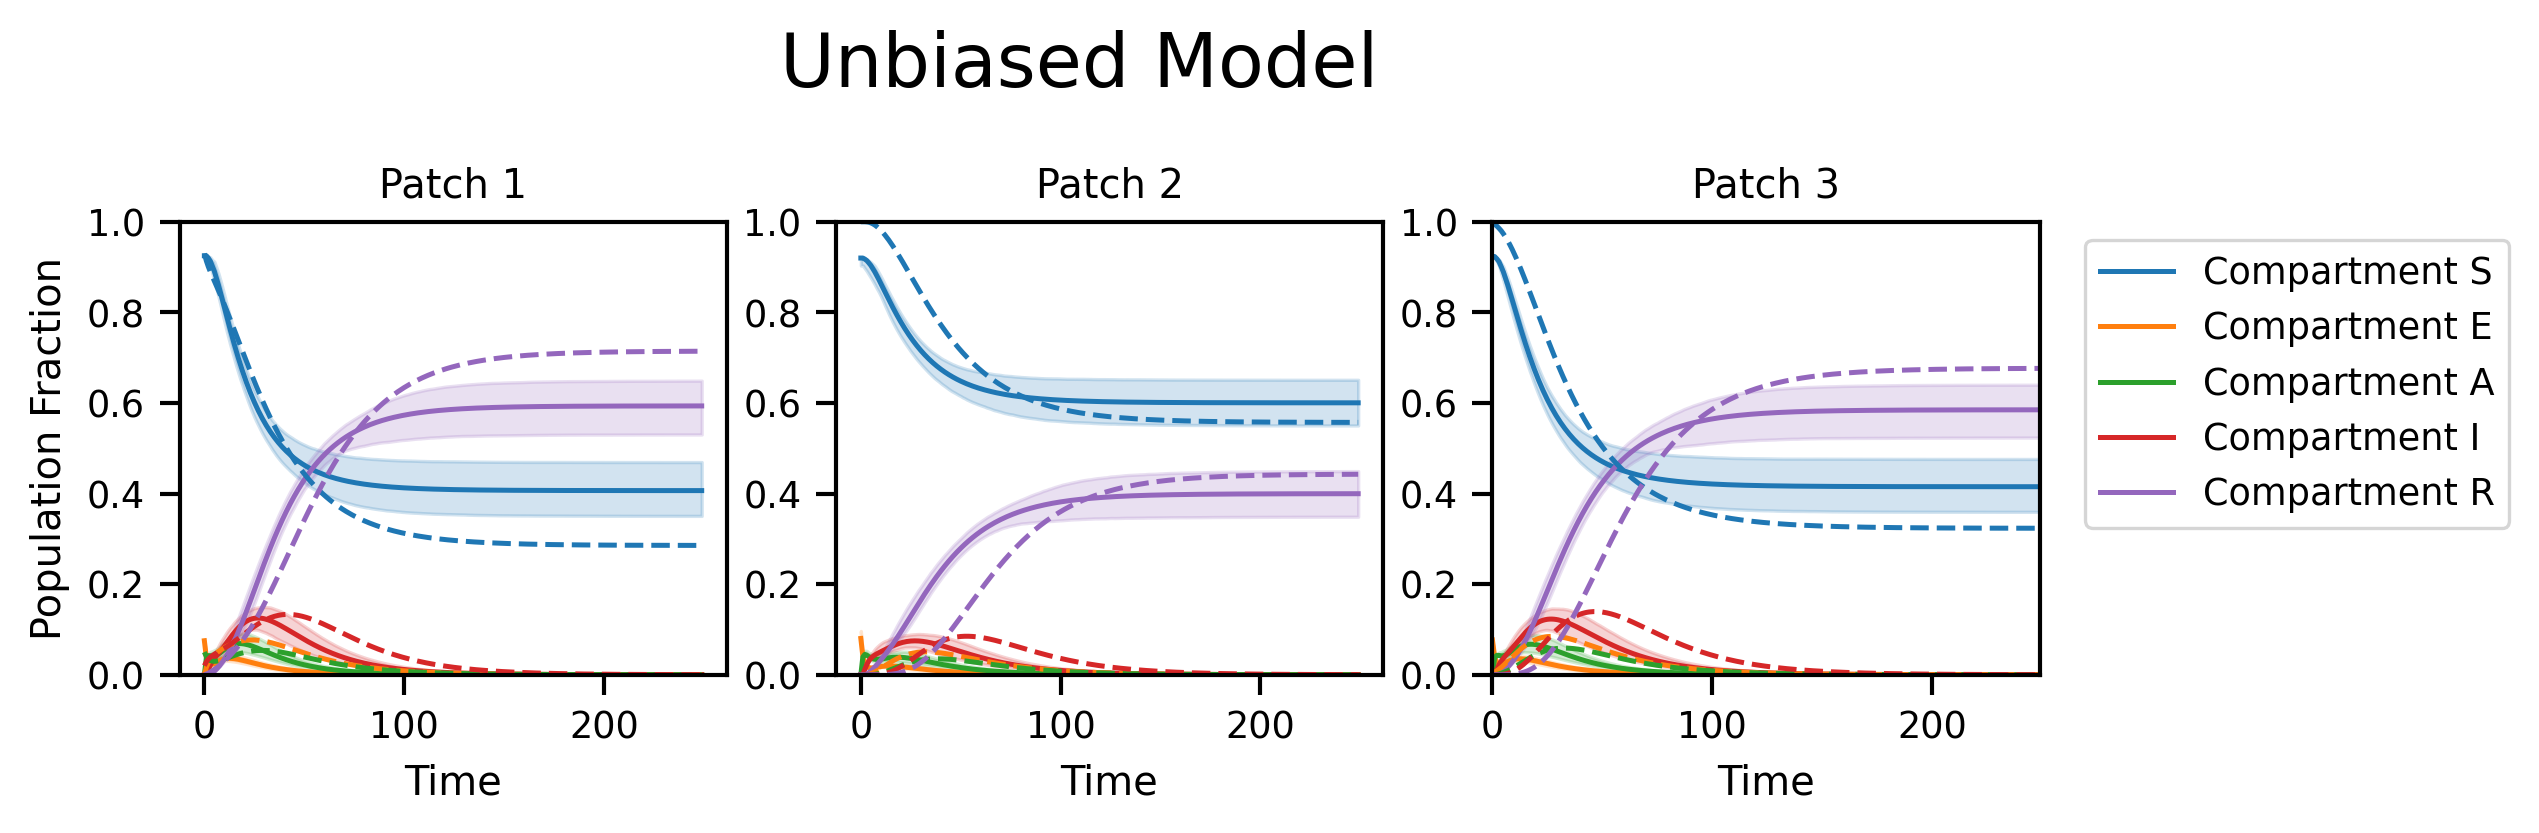

In [175]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

In [176]:
if not USE_CACHED_RESULTS:
    me_model = maxent.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)
    me_w = me_model.traj_weights
    np.save('epidemiology_files/maxent_biased_me_w', me_w)
else:
    me_w = np.load('epidemiology_files/maxent_biased_me_w.npy')

Epoch 1/1000
1/1 [==============================] - 0s 418ms/step - loss: 0.0043 - weight-entropy: 9.0092
Epoch 2/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 9.0100
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0041 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0040 - weight-entropy: 9.0104
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 9.0099
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 9.0089
Epoch 7/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0038 - weight-entropy: 9.0074
Epoch 8/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0037 - weight-entropy: 9.0055
Epoch 9/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 9.0030
Epoch 10/1000
1/1 [==============================] - 0s 3ms/st

1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4864
Epoch 80/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4832
Epoch 81/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4802
Epoch 82/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4772
Epoch 83/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4743
Epoch 84/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4716
Epoch 85/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - weight-entropy: 8.4689
Epoch 86/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4663
Epoch 87/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - weight-entropy: 8.4638
Epoch 88/1000
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3668
Epoch 157/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3657
Epoch 158/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3647
Epoch 159/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3636
Epoch 160/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 8.3626
Epoch 161/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3615
Epoch 162/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3605
Epoch 163/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3595
Epoch 164/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017 - weight-entropy: 8.3584
Epoch 165/1000
1/1 [==============================] - 0s 4ms/

Epoch 233/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0016 - weight-entropy: 8.2941
Epoch 234/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2933
Epoch 235/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2924
Epoch 236/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2916
Epoch 237/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2907
Epoch 238/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2899
Epoch 239/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2890
Epoch 240/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016 - weight-entropy: 8.2882
Epoch 241/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 8.2873
Epoch 242/1000
1/1 [==========================

1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2321
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2314
Epoch 312/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.2306
Epoch 313/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2299
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2291
Epoch 315/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2284
Epoch 316/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.2276
Epoch 317/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.2269
Epoch 318/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.2261
Epoch 319/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1773
Epoch 388/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1766
Epoch 389/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1760
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1753
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1746
Epoch 392/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1740
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 8.1733
Epoch 394/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1726
Epoch 395/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0015 - weight-entropy: 8.1720
Epoch 396/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1285
Epoch 465/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.1279
Epoch 466/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1273
Epoch 467/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1267
Epoch 468/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0014 - weight-entropy: 8.1261
Epoch 469/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.1255
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1249
Epoch 471/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.1243
Epoch 472/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.1237
Epoch 473/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.0838
Epoch 542/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.0832
Epoch 543/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0826
Epoch 544/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.0820
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0815
Epoch 546/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0809
Epoch 547/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0014 - weight-entropy: 8.0803
Epoch 548/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0797
Epoch 549/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 8.0791
Epoch 550/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0374
Epoch 619/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 8.0367
Epoch 620/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 8.0361
Epoch 621/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0354
Epoch 622/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0348
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0341
Epoch 624/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 8.0334
Epoch 625/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 8.0328
Epoch 626/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 8.0321
Epoch 627/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9793
Epoch 696/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9784
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9775
Epoch 698/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9766
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 7.9757
Epoch 700/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9748
Epoch 701/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9739
Epoch 702/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9730
Epoch 703/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 7.9721
Epoch 704/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8983
Epoch 773/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8971
Epoch 774/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 7.8958
Epoch 775/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0011 - weight-entropy: 7.8946
Epoch 776/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 7.8933
Epoch 777/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 7.8921
Epoch 778/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8908
Epoch 779/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8895
Epoch 780/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 7.8883
Epoch 781/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 5ms/step - loss: 0.0010 - weight-entropy: 7.7902
Epoch 849/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 7.7886
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 7.7870
Epoch 851/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7854
Epoch 852/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0010 - weight-entropy: 7.7837
Epoch 853/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0010 - weight-entropy: 7.7821
Epoch 854/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 7.7805
Epoch 855/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7788
Epoch 856/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 7.7772
Epoch 857/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 4ms/step - loss: 9.4976e-04 - weight-entropy: 7.6568
Epoch 924/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.4864e-04 - weight-entropy: 7.6549
Epoch 925/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.4751e-04 - weight-entropy: 7.6530
Epoch 926/1000
1/1 [==============================] - 0s 5ms/step - loss: 9.4638e-04 - weight-entropy: 7.6510
Epoch 927/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.4526e-04 - weight-entropy: 7.6491
Epoch 928/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4414e-04 - weight-entropy: 7.6471
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.4303e-04 - weight-entropy: 7.6452
Epoch 930/1000
1/1 [==============================] - 0s 5ms/step - loss: 9.4190e-04 - weight-entropy: 7.6432
Epoch 931/1000
1/1 [==============================] - 0s 4ms/step - loss: 9.4078e-04 - weight-entropy: 7.6412
Epoch 932/1000
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 8.6963e-04 - weight-entropy: 7.5043
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - loss: 8.6859e-04 - weight-entropy: 7.5021
Epoch 999/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.6757e-04 - weight-entropy: 7.5000
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 8.6653e-04 - weight-entropy: 7.4978


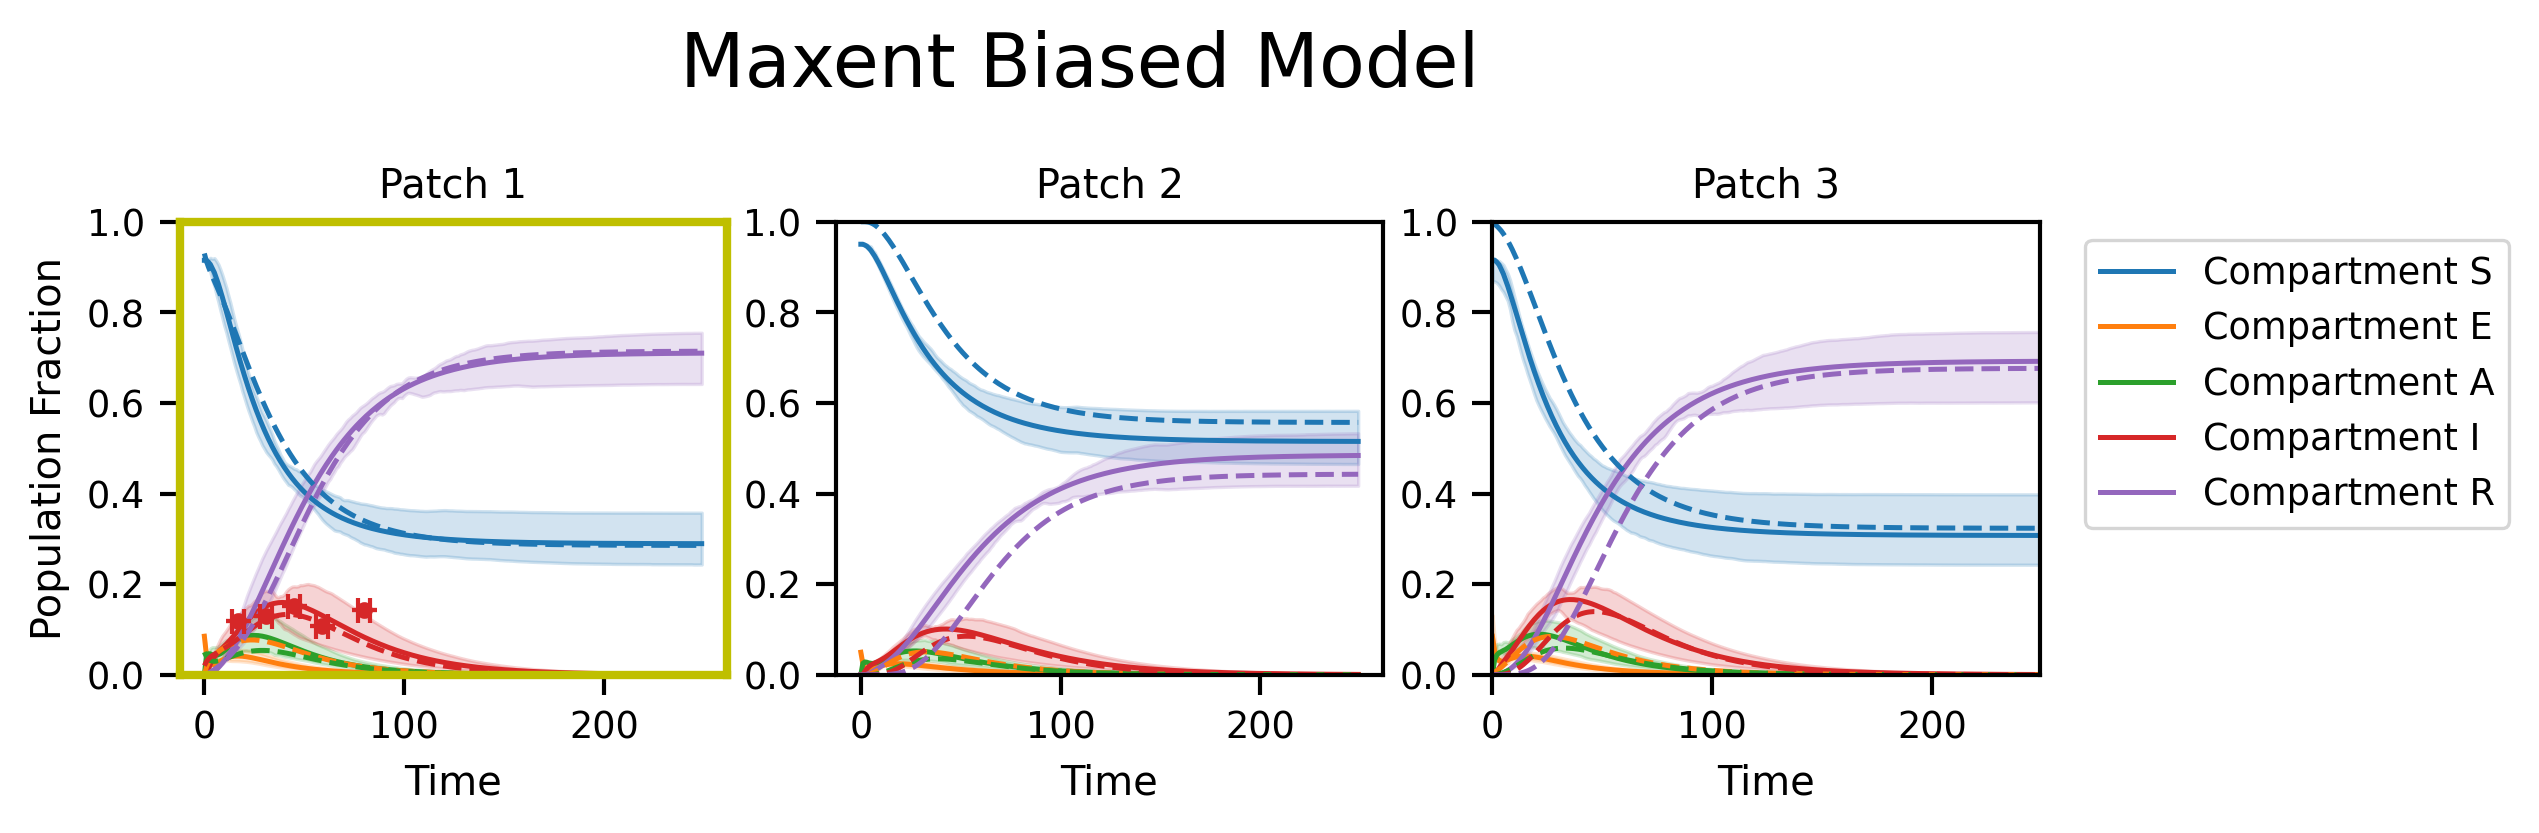

In [177]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [10]:
if not USE_CACHED_RESULTS:
    C = len(compartments)
    start = np.zeros((M, C))
    start[0,1] = 0.001
    start[0,2] = 0.001
    beta_start = 0.1
    infect = py0.ContactInfectionLayer(beta_start, infections_compartments)
    # make "agreement" function
    def agreement(traj, rs=restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, agreement)
    rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj = rmodel.get_traj()
    rmodel.fit(timesteps)
    regressed_traj = rmodel.get_traj()
    np.save('epidemiology_files/ls_biased_traj', regressed_traj)
else:
    regressed_traj = np.load('epidemiology_files/ls_biased_traj.npy')

250/250 [==============================] - 10s 36ms/step - loss: 0.0055 - output_2_loss: 0.0055


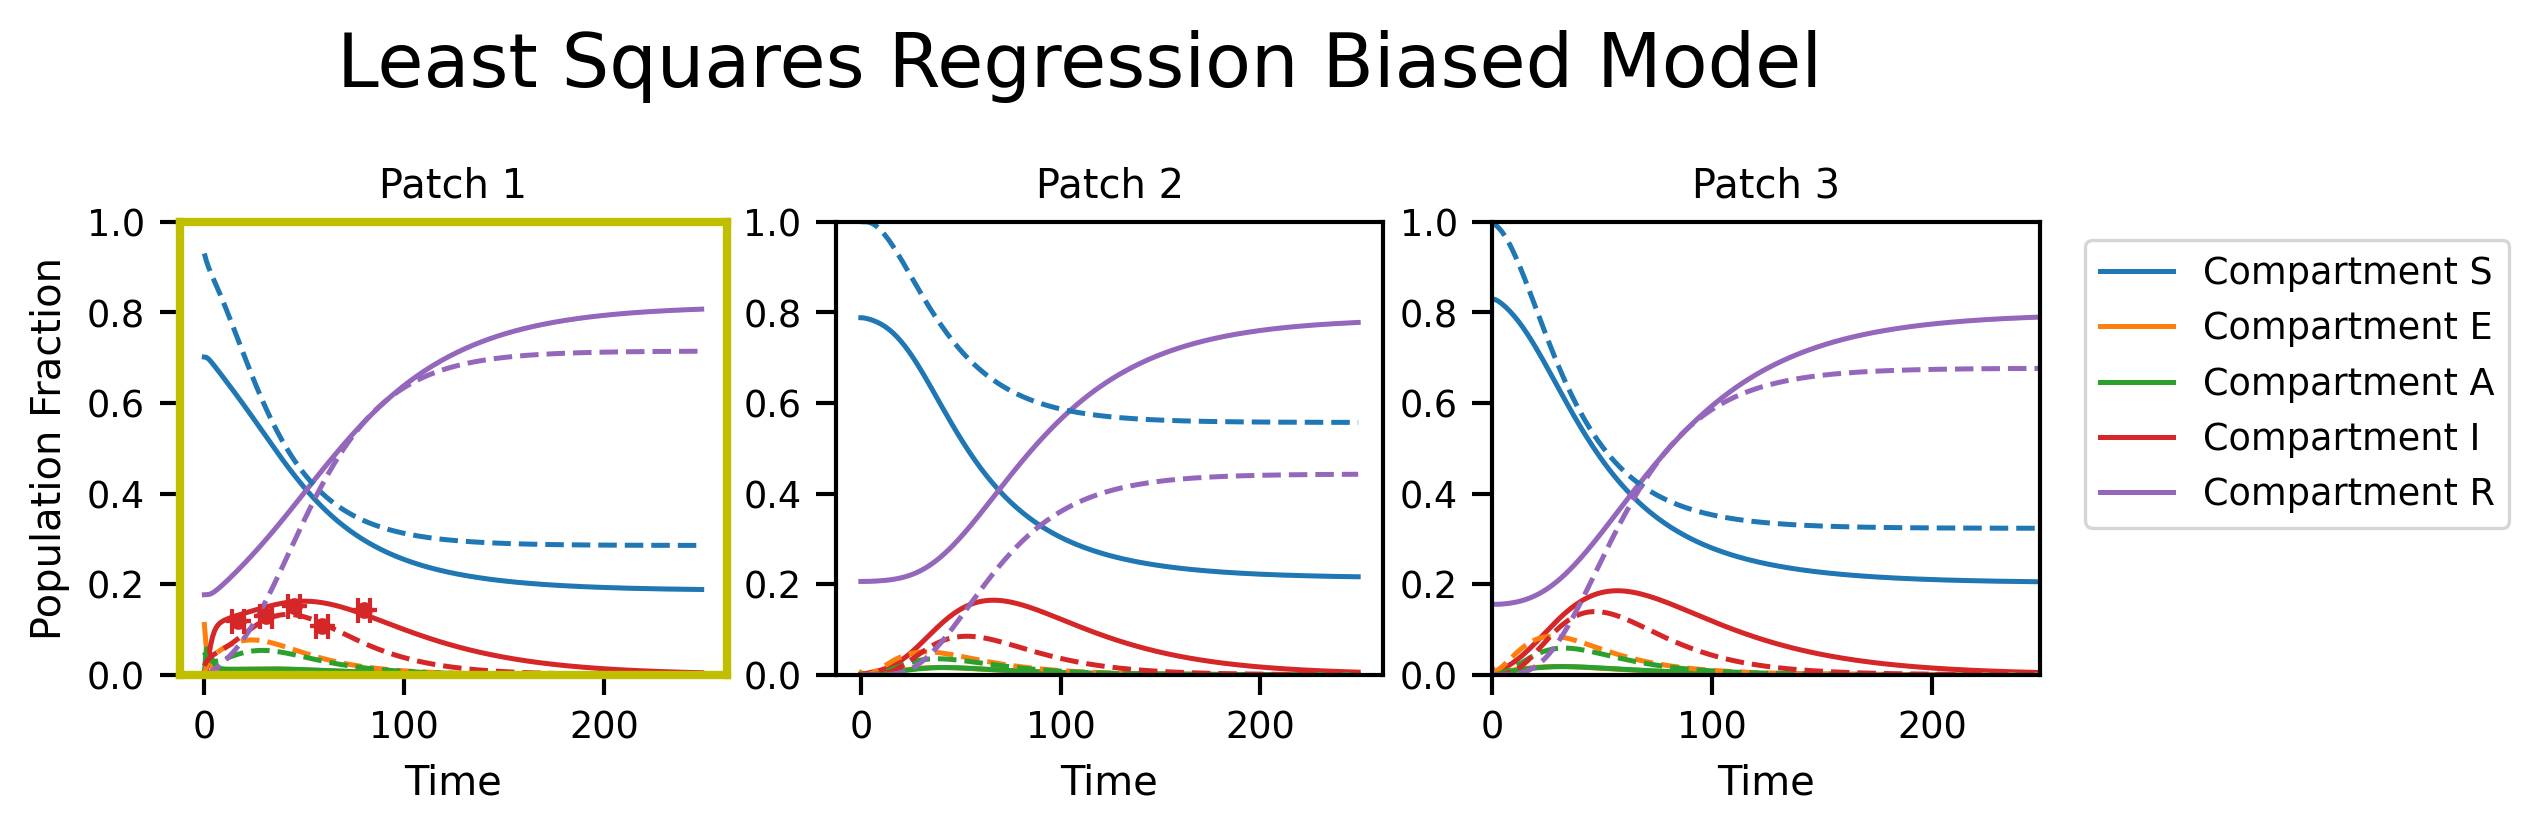

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regression Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## abc

In [16]:
np.random.seed(0)
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10
abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def abc_model(parameter):
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
if not USE_CACHED_RESULTS:
    parameter_priors = pyabc.Distribution(
                                    start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                    start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                    E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                    A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                    I_time=pyabc.RV('norm', abc_param_values[4], 5))

    abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db') 
    observation = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation})
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    df, w_abc = history.get_distribution(m=0, t=history.max_t)
    abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
    for i, row in enumerate(tqdm.tqdm(np.array(df))):
        A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
        traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
        abc_trajs[i] = traj
    abc_biased_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
    np.save('epidemiology_files/abc_biased_traj.npy', abc_biased_traj)
else:
    abc_biased_traj = np.load('epidemiology_files/abc_biased_traj.npy')

INFO:Sampler:Parallelizing the sampling on 16 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4947641586901674
INFO:ABC:t: 0, eps: 0.4947641586901674.
INFO:ABC:Acceptance rate: 100 / 219 = 4.5662e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38435913315826437.
INFO:ABC:Acceptance rate: 100 / 239 = 4.1841e-01, ESS=6.2138e+01.
INFO:ABC:t: 2, eps: 0.3287198206807549.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=5.5395e+01.
INFO:ABC:t: 3, eps: 0.2875645439526921.
INFO:ABC:Acceptance rate: 100 / 240 = 4.1667e-01, ESS=5.6249e+01.
INFO:ABC:t: 4, eps: 0.24658838319088924.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=4.2200e+01.
INFO:History:Done <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=2021-08-03 20:28:56.873078)>
100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


## 5-fold cross validation

In [ ]:
if not USE_CACHED_CV5_RESULTS:
    LS_traj_folds = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
    MaxEnt_traj_folds = np.empty_like(LS_traj_folds)
    abc_traj_folds = []
    for i in range(npoints):
        sampled_restraints = [n for n in restraints if n != restraints[i]]
        ## MaxEnt
        print(f'Initializing LS for fold {i}')
        def new_agreement(traj, rs=sampled_restraints):
            s = 0
            for r in rs:
                s += r(traj[0])**2
            return s
        rmodel_sampled = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, new_agreement)
        rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
        utraj_sampled = rmodel_sampled.get_traj()
        rmodel_sampled.fit(timesteps)
        regressed_traj_sampled = rmodel_sampled.get_traj()
        LS_traj_folds[i,:,:,:] = regressed_traj_sampled
        ## MaxEnt
        print(f'Initializing MaxEnt for fold {i}')
        me_model_sample = py0.MaxentModel(sampled_restraints, trajs=trajs, population_fraction=population_fraction)
        me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
        me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size, epochs=1000)
        MaxEnt_traj_folds[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        ## ABC
        print(f'Initializing ABC for fold {i}')
        def abc_model(parameter):
            trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']),
                                        + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time']))
            restrainted_time_values = [59, 45, 31, 80, 17]
            restrainted_time_values.pop(i)
            values = np.array([trajectory[m, 0, 3].numpy()
                               for m in restrainted_time_values])
            return {'data': values}
        parameter_priors = pyabc.Distribution(
                                        start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                        start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                        E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                        A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                        I_time=pyabc.RV('norm', abc_param_values[4], 5))

        abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
        db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db')
        observation_abc = np.array([r.target for r in sampled_restraints])
        abc.new(db_path, {'data': observation_abc})
        history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
        df, w_abc = history.get_distribution(m=0, t=history.max_t)
        abc_trajs = np.empty(
            (len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
        for j, row in enumerate(tqdm.tqdm(np.array(df))):
            A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc = row[
                0], row[1], row[2], row[3], row[4]
            traj = metapop_wraper(
                abs(start_infected_abc), abs(start_asymptomatic_abc), E_time_abc, A_time_abc, I_time_abc)
            abc_trajs[j] = traj
        mean_abc_traj = np.sum(
                abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        abc_traj_folds.append(mean_abc_traj)
    np.save('epidemiology_files/abc_traj_folds.npy', abc_traj_folds)
    np.save('epidemiology_files/MaxEnt_traj_folds.npy', MaxEnt_traj_folds)
    np.save('epidemiology_files/LS_traj_folds.npy', LS_traj_folds)
abc_traj_folds = np.load('epidemiology_files/abc_traj_folds.npy')
MaxEnt_traj_folds = np.load('epidemiology_files/MaxEnt_traj_folds.npy')
LS_traj_folds = np.load('epidemiology_files/LS_traj_folds.npy')

In [ ]:
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_traj_folds)
std_MaxEnt = find_std(MaxEnt_traj_folds)
std_LS = find_std(LS_traj_folds)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)


In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None,
                       values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(trajs * me_w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
qtrajs_maxentbiased = np.apply_along_axis(lambda x: weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_w), 0, trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)

axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_biased_traj[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])


# Variational Inference

In [193]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

def recip_norm_mat_dist(trans_times, trans_times_var, indices, sample_R=True, low=1):
    values = tf.gather_nd(trans_times, indices)
    v_vars = tf.gather_nd(trans_times_var, indices)
    print(values, v_vars)
    if sample_R:
        j = tfd.Normal(loc=values, scale=v_vars)
    else:
        j = tfd.Independent(tfd.TransformedDistribution(
            tfd.TruncatedNormal(loc=tf.clip_by_value(
                values, 1 + 1e-3, 1e10), scale=v_vars, low=low, high=1e10),
            bijector=tfb.Reciprocal()
        ), 1)
    return j



def normal_mat_layer(input, start, name, start_var=1, clip_high=1e10):
    '''Normally distributed trainable distribution. Zeros in mobility matrix are preserved'''
    # stack variance
    start_val = np.concatenate((
        start[np.newaxis, ...],
        np.tile(start_var, start.shape)[np.newaxis, ...]
    ))
    indices = tf.cast(tf.where(start > 0), tf.int32)
    x = py0.TrainableInputLayer(start_val, name=name + '-hypers',
                            constraint=py0.PositiveMaskedConstraint(start_val > 0))(input)
    x = tf.keras.layers.Lambda(
        lambda x: x + 1e-20 * np.mean(start), name=name + '-jitter')(x)
    d = tfp.layers.DistributionLambda(lambda t: recip_norm_mat_dist(
        t[0, 0], t[0, 1], indices), name=name + '-dist')(x)

    def reshaper(x, L=start.shape[0], indices=indices):
        if tf.rank(x) == 1:
            x = x[tf.newaxis, ...]
        mat = tf.map_fn(lambda v: tf.scatter_nd(indices, v, (L, L)), x)
        return mat/tf.reduce_sum(mat, axis=-1, keepdims=True)
    return d, reshaper

class MetaParameterJoint(py0.ParameterJoint):
    def __init__(self, start_logits, mobility_matrix,
                 transition_matrix,
                 name='', hypers=None, n_infectious_compartments=1):
        '''Create trainable joint model for parameters'''
        if hypers is None:
            hypers = ParameterHypers()
        dense_layer_size = n_infectious_compartments
        beta_low = hypers.beta_low
        beta_high = hypers.beta_high
        beta_var = hypers.beta_var
        i = tf.keras.layers.Input((1,))
        # infection parameter first
        beta_layer = tf.keras.layers.Dense(
            dense_layer_size,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.Constant(
                tf.math.log(hypers.beta_start)),
            name='beta')
        beta_dist = tfp.layers.DistributionLambda(
            lambda b: tfd.Independent(tfd.TruncatedNormal(
                loc=tf.clip_by_value(tf.math.sigmoid(
                    b[..., :]), beta_low, beta_high),
                scale=beta_var,
                low=beta_low,
                high=beta_high), 1),
            name='beta-dist'
        )(beta_layer(i))
        R_dist = normal_mat_layer(
            i, mobility_matrix,  start_var=hypers.R_var, name='R-dist')
        T_dist = py0.recip_norm_mat_layer(
            i, *transition_matrix.prior_matrix(), name='T-dist')
        start_dist = py0.categorical_normal_layer(
            i, start_logits, hypers.start_mean, hypers.start_scale, len(transition_matrix.names) - 1, name='rho-dist', start_high=hypers.start_high)
        reshapers = [R_dist[1], T_dist[1], start_dist[1], lambda x: x]
        super(MetaParameterJoint, self).__init__(reshapers=reshapers, inputs=i, outputs=[
            R_dist[0], T_dist[0], start_dist[0], beta_dist], name=name + '-model')

In [194]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_var = 0.000001
hyper_pram.beta_start = 0.025
hyper_pram.beta_high = 0.02500002
hyper_pram.beta_low = 0.025000001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.8
hyper_pram.R_var = 0
param_model = MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)
sample_params = param_model.sample(1)
print(f'\nsample R: {sample_params[0]}')
print(f'\ntrue R: {R_norm}')

Tensor("R-dist-dist/GatherNd:0", shape=(8,), dtype=float32) Tensor("R-dist-dist/GatherNd_1:0", shape=(8,), dtype=float32)
tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)

sample R: [[[0.513133   0.482345   0.00452198]
  [0.         0.72727275 0.27272728]
  [0.15904573 0.37375745 0.46719682]]]

true R: [[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]


In [197]:
fit_param_model = MetaParameterJoint(start_logits, R_norm , tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model, reweight=True)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=0.1), 'mean_squared_error')

Tensor("R-dist-dist/GatherNd:0", shape=(8,), dtype=float32) Tensor("R-dist-dist/GatherNd_1:0", shape=(8,), dtype=float32)
tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)


In [198]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=5, param_epochs=1000, batch_size=batch_size, epochs=1000, verbose=0)

tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)


Epoch 1/1000
Tensor("unbiased_model-model/R-dist-dist/GatherNd:0", shape=(8,), dtype=float32) Tensor("unbiased_model-model/R-dist-dist/GatherNd_1:0", shape=(8,), dtype=float32)
Tensor("unbiased_model-model/R-dist-dist/GatherNd:0", shape=(8,), dtype=float32) Tensor("unbiased_model-model/R-dist-dist/GatherNd_1:0", shape=(8,), dtype=float32)
64/64 [==============================] - 4s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.1238e-04 - beta-dist_loss: -0.2766
Epoch 2/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0018 - rho-dist-dist_loss: -7.9853e-04 - beta-dist_loss: -0.2766
Epoch 3/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0585e-04 - beta-dist_loss: -0.2766
Epoch 4/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4

64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0756e-04 - beta-dist_loss: -0.2766
Epoch 41/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0592e-04 - beta-dist_loss: -0.2766
Epoch 42/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0435e-04 - beta-dist_loss: -0.2766
Epoch 43/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0765e-04 - beta-dist_loss: -0.2766
Epoch 44/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0370e-04 - beta-dist_loss: -0.2766
Epoch 45/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0752e-04 - beta-dist_loss: -0.2766
Epoch 82/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9932e-04 - beta-dist_loss: -0.2766
Epoch 83/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9527e-04 - beta-dist_loss: -0.2766
Epoch 84/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0850e-04 - beta-dist_loss: -0.2766
Epoch 85/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1280e-04 - beta-dist_loss: -0.2766
Epoch 86/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1310e-04 - beta-dist_loss: -0.2766
Epoch 123/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0293e-04 - beta-dist_loss: -0.2766
Epoch 124/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0774e-04 - beta-dist_loss: -0.2766
Epoch 125/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1024e-04 - beta-dist_loss: -0.2766
Epoch 126/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0562e-04 - beta-dist_loss: -0.2766
Epoch 127/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9460e-04 - beta-dist_loss: -0.2766
Epoch 164/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9481e-04 - beta-dist_loss: -0.2766
Epoch 165/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9527e-04 - beta-dist_loss: -0.2766
Epoch 166/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9494e-04 - beta-dist_loss: -0.2766
Epoch 167/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0802e-04 - beta-dist_loss: -0.2766
Epoch 168/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0805e-04 - beta-dist_loss: -0.2766
Epoch 205/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0929e-04 - beta-dist_loss: -0.2766
Epoch 206/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9849e-04 - beta-dist_loss: -0.2766
Epoch 207/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0010e-04 - beta-dist_loss: -0.2766
Epoch 208/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0429e-04 - beta-dist_loss: -0.2766
Epoch 209/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0803e-04 - beta-dist_loss: -0.2766
Epoch 246/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1088e-04 - beta-dist_loss: -0.2766
Epoch 247/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0288e-04 - beta-dist_loss: -0.2766
Epoch 248/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1093e-04 - beta-dist_loss: -0.2766
Epoch 249/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9458e-04 - beta-dist_loss: -0.2766
Epoch 250/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0447e-04 - beta-dist_loss: -0.2766
Epoch 287/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0881e-04 - beta-dist_loss: -0.2766
Epoch 288/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9912e-04 - beta-dist_loss: -0.2766
Epoch 289/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0069e-04 - beta-dist_loss: -0.2766
Epoch 290/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0079e-04 - beta-dist_loss: -0.2766
Epoch 291/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1297e-04 - beta-dist_loss: -0.2766
Epoch 328/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1140e-04 - beta-dist_loss: -0.2766
Epoch 329/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1350e-04 - beta-dist_loss: -0.2766
Epoch 330/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0720e-04 - beta-dist_loss: -0.2766
Epoch 331/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1289e-04 - beta-dist_loss: -0.2766
Epoch 332/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0723e-04 - beta-dist_loss: -0.2766
Epoch 369/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0924e-04 - beta-dist_loss: -0.2766
Epoch 370/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0645e-04 - beta-dist_loss: -0.2766
Epoch 371/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9776e-04 - beta-dist_loss: -0.2766
Epoch 372/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0685e-04 - beta-dist_loss: -0.2766
Epoch 373/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9585e-04 - beta-dist_loss: -0.2766
Epoch 410/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1187e-04 - beta-dist_loss: -0.2766
Epoch 411/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9655e-04 - beta-dist_loss: -0.2766
Epoch 412/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0537e-04 - beta-dist_loss: -0.2766
Epoch 413/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0036e-04 - beta-dist_loss: -0.2766
Epoch 414/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0741e-04 - beta-dist_loss: -0.2766
Epoch 451/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9992e-04 - beta-dist_loss: -0.2766
Epoch 452/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9988e-04 - beta-dist_loss: -0.2766
Epoch 453/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0079e-04 - beta-dist_loss: -0.2766
Epoch 454/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0777e-04 - beta-dist_loss: -0.2766
Epoch 455/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0723e-04 - beta-dist_loss: -0.2766
Epoch 492/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1265e-04 - beta-dist_loss: -0.2766
Epoch 493/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9834e-04 - beta-dist_loss: -0.2766
Epoch 494/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9115e-04 - beta-dist_loss: -0.2766
Epoch 495/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9512e-04 - beta-dist_loss: -0.2766
Epoch 496/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0595e-04 - beta-dist_loss: -0.2766
Epoch 533/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0110e-04 - beta-dist_loss: -0.2766
Epoch 534/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0518e-04 - beta-dist_loss: -0.2766
Epoch 535/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0754e-04 - beta-dist_loss: -0.2766
Epoch 536/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0113e-04 - beta-dist_loss: -0.2766
Epoch 537/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0733e-04 - beta-dist_loss: -0.2766
Epoch 574/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0942e-04 - beta-dist_loss: -0.2766
Epoch 575/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0532e-04 - beta-dist_loss: -0.2766
Epoch 576/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0701e-04 - beta-dist_loss: -0.2766
Epoch 577/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0778e-04 - beta-dist_loss: -0.2766
Epoch 578/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0575e-04 - beta-dist_loss: -0.2766
Epoch 615/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0042e-04 - beta-dist_loss: -0.2766
Epoch 616/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0578e-04 - beta-dist_loss: -0.2766
Epoch 617/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0644e-04 - beta-dist_loss: -0.2766
Epoch 618/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0791e-04 - beta-dist_loss: -0.2766
Epoch 619/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9963e-04 - beta-dist_loss: -0.2766
Epoch 656/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0543e-04 - beta-dist_loss: -0.2766
Epoch 657/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1139e-04 - beta-dist_loss: -0.2766
Epoch 658/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0743e-04 - beta-dist_loss: -0.2766
Epoch 659/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0480e-04 - beta-dist_loss: -0.2766
Epoch 660/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9423e-04 - beta-dist_loss: -0.2766
Epoch 697/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9246e-04 - beta-dist_loss: -0.2766
Epoch 698/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0452e-04 - beta-dist_loss: -0.2766
Epoch 699/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0298e-04 - beta-dist_loss: -0.2766
Epoch 700/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0416e-04 - beta-dist_loss: -0.2766
Epoch 701/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1068e-04 - beta-dist_loss: -0.2766
Epoch 738/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0427e-04 - beta-dist_loss: -0.2766
Epoch 739/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0702e-04 - beta-dist_loss: -0.2766
Epoch 740/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0486e-04 - beta-dist_loss: -0.2766
Epoch 741/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9812e-04 - beta-dist_loss: -0.2766
Epoch 742/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9786e-04 - beta-dist_loss: -0.2766
Epoch 779/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0970e-04 - beta-dist_loss: -0.2766
Epoch 780/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0928e-04 - beta-dist_loss: -0.2766
Epoch 781/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9530e-04 - beta-dist_loss: -0.2766
Epoch 782/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0963e-04 - beta-dist_loss: -0.2766
Epoch 783/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0476e-04 - beta-dist_loss: -0.2766
Epoch 820/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0484e-04 - beta-dist_loss: -0.2766
Epoch 821/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9448e-04 - beta-dist_loss: -0.2766
Epoch 822/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0743e-04 - beta-dist_loss: -0.2766
Epoch 823/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0239e-04 - beta-dist_loss: -0.2766
Epoch 824/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.8510e-04 - beta-dist_loss: -0.2766
Epoch 861/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0588e-04 - beta-dist_loss: -0.2766
Epoch 862/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9766e-04 - beta-dist_loss: -0.2766
Epoch 863/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9822e-04 - beta-dist_loss: -0.2766
Epoch 864/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0349e-04 - beta-dist_loss: -0.2766
Epoch 865/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0004e-04 - beta-dist_loss: -0.2766
Epoch 902/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0158e-04 - beta-dist_loss: -0.2766
Epoch 903/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0865e-04 - beta-dist_loss: -0.2766
Epoch 904/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9764e-04 - beta-dist_loss: -0.2766
Epoch 905/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9484e-04 - beta-dist_loss: -0.2766
Epoch 906/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.1171e-04 - beta-dist_loss: -0.2766
Epoch 943/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0070e-04 - beta-dist_loss: -0.2766
Epoch 944/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0198e-04 - beta-dist_loss: -0.2766
Epoch 945/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0711e-04 - beta-dist_loss: -0.2766
Epoch 946/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0295e-04 - beta-dist_loss: -0.2766
Epoch 947/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0909e-04 - beta-dist_loss: -0.2766
Epoch 984/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0763e-04 - beta-dist_loss: -0.2766
Epoch 985/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0581e-04 - beta-dist_loss: -0.2766
Epoch 986/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -8.0732e-04 - beta-dist_loss: -0.2766
Epoch 987/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4594 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0019 - rho-dist-dist_loss: -7.9298e-04 - beta-dist_loss: -0.2766
Epoch 988/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5856e-04 - beta-dist_loss: -0.2766
Epoch 23/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6638e-04 - beta-dist_loss: -0.2766
Epoch 24/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7180e-04 - beta-dist_loss: -0.2766
Epoch 25/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7448e-04 - beta-dist_loss: -0.2766
Epoch 26/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7511e-04 - beta-dist_loss: -0.2766
Epoch 27/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6580e-04 - beta-dist_loss: -0.2766
Epoch 64/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6898e-04 - beta-dist_loss: -0.2766
Epoch 65/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7623e-04 - beta-dist_loss: -0.2766
Epoch 66/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6162e-04 - beta-dist_loss: -0.2766
Epoch 67/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6767e-04 - beta-dist_loss: -0.2766
Epoch 68/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6457e-04 - beta-dist_loss: -0.2766
Epoch 105/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7140e-04 - beta-dist_loss: -0.2766
Epoch 106/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6753e-04 - beta-dist_loss: -0.2766
Epoch 107/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7344e-04 - beta-dist_loss: -0.2766
Epoch 108/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.6508e-04 - beta-dist_loss: -0.2766
Epoch 109/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7268e-04 - beta-dist_loss: -0.2766
Epoch 146/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6747e-04 - beta-dist_loss: -0.2766
Epoch 147/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7611e-04 - beta-dist_loss: -0.2766
Epoch 148/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6160e-04 - beta-dist_loss: -0.2766
Epoch 149/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6842e-04 - beta-dist_loss: -0.2766
Epoch 150/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7177e-04 - beta-dist_loss: -0.2766
Epoch 187/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7229e-04 - beta-dist_loss: -0.2766
Epoch 188/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7099e-04 - beta-dist_loss: -0.2766
Epoch 189/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7109e-04 - beta-dist_loss: -0.2766
Epoch 190/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5957e-04 - beta-dist_loss: -0.2766
Epoch 191/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6560e-04 - beta-dist_loss: -0.2766
Epoch 228/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7833e-04 - beta-dist_loss: -0.2766
Epoch 229/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6339e-04 - beta-dist_loss: -0.2766
Epoch 230/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6082e-04 - beta-dist_loss: -0.2766
Epoch 231/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7150e-04 - beta-dist_loss: -0.2766
Epoch 232/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6045e-04 - beta-dist_loss: -0.2766
Epoch 269/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6278e-04 - beta-dist_loss: -0.2766
Epoch 270/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7076e-04 - beta-dist_loss: -0.2766
Epoch 271/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6956e-04 - beta-dist_loss: -0.2766
Epoch 272/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6033e-04 - beta-dist_loss: -0.2766
Epoch 273/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6495e-04 - beta-dist_loss: -0.2766
Epoch 310/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6211e-04 - beta-dist_loss: -0.2766
Epoch 311/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.5966e-04 - beta-dist_loss: -0.2766
Epoch 312/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7071e-04 - beta-dist_loss: -0.2766
Epoch 313/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6980e-04 - beta-dist_loss: -0.2766
Epoch 314/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7027e-04 - beta-dist_loss: -0.2766
Epoch 351/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7219e-04 - beta-dist_loss: -0.2766
Epoch 352/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5931e-04 - beta-dist_loss: -0.2766
Epoch 353/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6534e-04 - beta-dist_loss: -0.2766
Epoch 354/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6246e-04 - beta-dist_loss: -0.2766
Epoch 355/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7619e-04 - beta-dist_loss: -0.2766
Epoch 392/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6222e-04 - beta-dist_loss: -0.2766
Epoch 393/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6698e-04 - beta-dist_loss: -0.2766
Epoch 394/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7133e-04 - beta-dist_loss: -0.2766
Epoch 395/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7669e-04 - beta-dist_loss: -0.2766
Epoch 396/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6193e-04 - beta-dist_loss: -0.2766
Epoch 433/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6336e-04 - beta-dist_loss: -0.2766
Epoch 434/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6561e-04 - beta-dist_loss: -0.2766
Epoch 435/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6538e-04 - beta-dist_loss: -0.2766
Epoch 436/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6952e-04 - beta-dist_loss: -0.2766
Epoch 437/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7094e-04 - beta-dist_loss: -0.2766
Epoch 474/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6011e-04 - beta-dist_loss: -0.2766
Epoch 475/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7380e-04 - beta-dist_loss: -0.2766
Epoch 476/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7538e-04 - beta-dist_loss: -0.2766
Epoch 477/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6549e-04 - beta-dist_loss: -0.2766
Epoch 478/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7506e-04 - beta-dist_loss: -0.2766
Epoch 515/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6825e-04 - beta-dist_loss: -0.2766
Epoch 516/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6859e-04 - beta-dist_loss: -0.2766
Epoch 517/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6356e-04 - beta-dist_loss: -0.2766
Epoch 518/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6723e-04 - beta-dist_loss: -0.2766
Epoch 519/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7125e-04 - beta-dist_loss: -0.2766
Epoch 556/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7193e-04 - beta-dist_loss: -0.2766
Epoch 557/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6143e-04 - beta-dist_loss: -0.2766
Epoch 558/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6631e-04 - beta-dist_loss: -0.2766
Epoch 559/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6800e-04 - beta-dist_loss: -0.2766
Epoch 560/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6894e-04 - beta-dist_loss: -0.2766
Epoch 597/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6529e-04 - beta-dist_loss: -0.2766
Epoch 598/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7336e-04 - beta-dist_loss: -0.2766
Epoch 599/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7017e-04 - beta-dist_loss: -0.2766
Epoch 600/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6686e-04 - beta-dist_loss: -0.2766
Epoch 601/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6953e-04 - beta-dist_loss: -0.2766
Epoch 638/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6401e-04 - beta-dist_loss: -0.2766
Epoch 639/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6665e-04 - beta-dist_loss: -0.2766
Epoch 640/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.6542e-04 - beta-dist_loss: -0.2766
Epoch 641/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6511e-04 - beta-dist_loss: -0.2766
Epoch 642/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6895e-04 - beta-dist_loss: -0.2766
Epoch 679/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7841e-04 - beta-dist_loss: -0.2766
Epoch 680/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7654e-04 - beta-dist_loss: -0.2766
Epoch 681/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6254e-04 - beta-dist_loss: -0.2766
Epoch 682/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6427e-04 - beta-dist_loss: -0.2766
Epoch 683/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7992e-04 - beta-dist_loss: -0.2766
Epoch 720/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5788e-04 - beta-dist_loss: -0.2766
Epoch 721/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6555e-04 - beta-dist_loss: -0.2766
Epoch 722/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6740e-04 - beta-dist_loss: -0.2766
Epoch 723/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6520e-04 - beta-dist_loss: -0.2766
Epoch 724/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7005e-04 - beta-dist_loss: -0.2766
Epoch 761/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7211e-04 - beta-dist_loss: -0.2766
Epoch 762/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7000e-04 - beta-dist_loss: -0.2766
Epoch 763/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7023e-04 - beta-dist_loss: -0.2766
Epoch 764/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6590e-04 - beta-dist_loss: -0.2766
Epoch 765/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7222e-04 - beta-dist_loss: -0.2766
Epoch 802/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6735e-04 - beta-dist_loss: -0.2766
Epoch 803/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7177e-04 - beta-dist_loss: -0.2766
Epoch 804/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5963e-04 - beta-dist_loss: -0.2766
Epoch 805/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6860e-04 - beta-dist_loss: -0.2766
Epoch 806/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.4786e-04 - beta-dist_loss: -0.2766
Epoch 843/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6373e-04 - beta-dist_loss: -0.2766
Epoch 844/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6310e-04 - beta-dist_loss: -0.2766
Epoch 845/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7350e-04 - beta-dist_loss: -0.2766
Epoch 846/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6683e-04 - beta-dist_loss: -0.2766
Epoch 847/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7523e-04 - beta-dist_loss: -0.2766
Epoch 884/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6833e-04 - beta-dist_loss: -0.2766
Epoch 885/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5525e-04 - beta-dist_loss: -0.2766
Epoch 886/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6253e-04 - beta-dist_loss: -0.2766
Epoch 887/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6898e-04 - beta-dist_loss: -0.2766
Epoch 888/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.5561e-04 - beta-dist_loss: -0.2766
Epoch 925/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6166e-04 - beta-dist_loss: -0.2766
Epoch 926/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7006e-04 - beta-dist_loss: -0.2766
Epoch 927/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6801e-04 - beta-dist_loss: -0.2766
Epoch 928/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7059e-04 - beta-dist_loss: -0.2766
Epoch 929/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7348e-04 - beta-dist_loss: -0.2766
Epoch 966/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7641e-04 - beta-dist_loss: -0.2766
Epoch 967/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.6929e-04 - beta-dist_loss: -0.2766
Epoch 968/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4593 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0017 - rho-dist-dist_loss: -8.7534e-04 - beta-dist_loss: -0.2766
Epoch 969/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.4966e-04 - beta-dist_loss: -0.2766
Epoch 970/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7401e-04 - beta-dist_loss: -0.2766
Epoch 5/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8575e-04 - beta-dist_loss: -0.2766
Epoch 6/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7889e-04 - beta-dist_loss: -0.2766
Epoch 7/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8048e-04 - beta-dist_loss: -0.2766
Epoch 8/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8115e-04 - beta-dist_loss: -0.2766
Epoch 9/1000
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8440e-04 - beta-dist_loss: -0.2766
Epoch 46/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7865e-04 - beta-dist_loss: -0.2766
Epoch 47/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7632e-04 - beta-dist_loss: -0.2766
Epoch 48/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8262e-04 - beta-dist_loss: -0.2766
Epoch 49/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8148e-04 - beta-dist_loss: -0.2766
Epoch 50/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7911e-04 - beta-dist_loss: -0.2766
Epoch 87/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7669e-04 - beta-dist_loss: -0.2766
Epoch 88/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7753e-04 - beta-dist_loss: -0.2766
Epoch 89/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8208e-04 - beta-dist_loss: -0.2766
Epoch 90/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.6947e-04 - beta-dist_loss: -0.2766
Epoch 91/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8128e-04 - beta-dist_loss: -0.2766
Epoch 128/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8057e-04 - beta-dist_loss: -0.2766
Epoch 129/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7856e-04 - beta-dist_loss: -0.2766
Epoch 130/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8230e-04 - beta-dist_loss: -0.2766
Epoch 131/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8294e-04 - beta-dist_loss: -0.2766
Epoch 132/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7292e-04 - beta-dist_loss: -0.2766
Epoch 169/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8573e-04 - beta-dist_loss: -0.2766
Epoch 170/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8148e-04 - beta-dist_loss: -0.2766
Epoch 171/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7747e-04 - beta-dist_loss: -0.2766
Epoch 172/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7903e-04 - beta-dist_loss: -0.2766
Epoch 173/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8342e-04 - beta-dist_loss: -0.2766
Epoch 210/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8430e-04 - beta-dist_loss: -0.2766
Epoch 211/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8325e-04 - beta-dist_loss: -0.2766
Epoch 212/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8116e-04 - beta-dist_loss: -0.2766
Epoch 213/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8307e-04 - beta-dist_loss: -0.2766
Epoch 214/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8397e-04 - beta-dist_loss: -0.2766
Epoch 251/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7795e-04 - beta-dist_loss: -0.2766
Epoch 252/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8436e-04 - beta-dist_loss: -0.2766
Epoch 253/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8112e-04 - beta-dist_loss: -0.2766
Epoch 254/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7964e-04 - beta-dist_loss: -0.2766
Epoch 255/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7907e-04 - beta-dist_loss: -0.2766
Epoch 292/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7768e-04 - beta-dist_loss: -0.2766
Epoch 293/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7948e-04 - beta-dist_loss: -0.2766
Epoch 294/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7906e-04 - beta-dist_loss: -0.2766
Epoch 295/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7510e-04 - beta-dist_loss: -0.2766
Epoch 296/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7635e-04 - beta-dist_loss: -0.2766
Epoch 333/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7851e-04 - beta-dist_loss: -0.2766
Epoch 334/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7682e-04 - beta-dist_loss: -0.2766
Epoch 335/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8033e-04 - beta-dist_loss: -0.2766
Epoch 336/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8011e-04 - beta-dist_loss: -0.2766
Epoch 337/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8171e-04 - beta-dist_loss: -0.2766
Epoch 374/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8804e-04 - beta-dist_loss: -0.2766
Epoch 375/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7538e-04 - beta-dist_loss: -0.2766
Epoch 376/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8094e-04 - beta-dist_loss: -0.2766
Epoch 377/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8135e-04 - beta-dist_loss: -0.2766
Epoch 378/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8199e-04 - beta-dist_loss: -0.2766
Epoch 415/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8324e-04 - beta-dist_loss: -0.2766
Epoch 416/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8050e-04 - beta-dist_loss: -0.2766
Epoch 417/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8223e-04 - beta-dist_loss: -0.2766
Epoch 418/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7993e-04 - beta-dist_loss: -0.2766
Epoch 419/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8121e-04 - beta-dist_loss: -0.2766
Epoch 456/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7751e-04 - beta-dist_loss: -0.2766
Epoch 457/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7812e-04 - beta-dist_loss: -0.2766
Epoch 458/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7899e-04 - beta-dist_loss: -0.2766
Epoch 459/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7913e-04 - beta-dist_loss: -0.2766
Epoch 460/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8330e-04 - beta-dist_loss: -0.2766
Epoch 497/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7944e-04 - beta-dist_loss: -0.2766
Epoch 498/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8008e-04 - beta-dist_loss: -0.2766
Epoch 499/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7891e-04 - beta-dist_loss: -0.2766
Epoch 500/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8007e-04 - beta-dist_loss: -0.2766
Epoch 501/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7978e-04 - beta-dist_loss: -0.2766
Epoch 538/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7887e-04 - beta-dist_loss: -0.2766
Epoch 539/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8193e-04 - beta-dist_loss: -0.2766
Epoch 540/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8408e-04 - beta-dist_loss: -0.2766
Epoch 541/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7885e-04 - beta-dist_loss: -0.2766
Epoch 542/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8387e-04 - beta-dist_loss: -0.2766
Epoch 579/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8198e-04 - beta-dist_loss: -0.2766
Epoch 580/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7981e-04 - beta-dist_loss: -0.2766
Epoch 581/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7982e-04 - beta-dist_loss: -0.2766
Epoch 582/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7389e-04 - beta-dist_loss: -0.2766
Epoch 583/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.6168e-04 - beta-dist_loss: -0.2766
Epoch 620/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7478e-04 - beta-dist_loss: -0.2766
Epoch 621/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8471e-04 - beta-dist_loss: -0.2766
Epoch 622/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8075e-04 - beta-dist_loss: -0.2766
Epoch 623/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7824e-04 - beta-dist_loss: -0.2766
Epoch 624/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8206e-04 - beta-dist_loss: -0.2766
Epoch 661/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7691e-04 - beta-dist_loss: -0.2766
Epoch 662/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.6903e-04 - beta-dist_loss: -0.2766
Epoch 663/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7451e-04 - beta-dist_loss: -0.2766
Epoch 664/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7753e-04 - beta-dist_loss: -0.2766
Epoch 665/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8019e-04 - beta-dist_loss: -0.2766
Epoch 702/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8170e-04 - beta-dist_loss: -0.2766
Epoch 703/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8097e-04 - beta-dist_loss: -0.2766
Epoch 704/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8522e-04 - beta-dist_loss: -0.2766
Epoch 705/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7262e-04 - beta-dist_loss: -0.2766
Epoch 706/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8073e-04 - beta-dist_loss: -0.2766
Epoch 743/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7305e-04 - beta-dist_loss: -0.2766
Epoch 744/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8438e-04 - beta-dist_loss: -0.2766
Epoch 745/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8102e-04 - beta-dist_loss: -0.2766
Epoch 746/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8187e-04 - beta-dist_loss: -0.2766
Epoch 747/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7845e-04 - beta-dist_loss: -0.2766
Epoch 784/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7760e-04 - beta-dist_loss: -0.2766
Epoch 785/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8436e-04 - beta-dist_loss: -0.2766
Epoch 786/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8229e-04 - beta-dist_loss: -0.2766
Epoch 787/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7868e-04 - beta-dist_loss: -0.2766
Epoch 788/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8398e-04 - beta-dist_loss: -0.2766
Epoch 825/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7994e-04 - beta-dist_loss: -0.2766
Epoch 826/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8358e-04 - beta-dist_loss: -0.2766
Epoch 827/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7715e-04 - beta-dist_loss: -0.2766
Epoch 828/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7655e-04 - beta-dist_loss: -0.2766
Epoch 829/1000


64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7941e-04 - beta-dist_loss: -0.2766
Epoch 866/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8334e-04 - beta-dist_loss: -0.2766
Epoch 867/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8751e-04 - beta-dist_loss: -0.2766
Epoch 868/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7318e-04 - beta-dist_loss: -0.2766
Epoch 869/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7644e-04 - beta-dist_loss: -0.2766
Epoch 870/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8300e-04 - beta-dist_loss: -0.2766
Epoch 907/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8246e-04 - beta-dist_loss: -0.2766
Epoch 908/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8211e-04 - beta-dist_loss: -0.2766
Epoch 909/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7482e-04 - beta-dist_loss: -0.2766
Epoch 910/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8550e-04 - beta-dist_loss: -0.2766
Epoch 911/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8221e-04 - beta-dist_loss: -0.2766
Epoch 948/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8003e-04 - beta-dist_loss: -0.2766
Epoch 949/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.6550e-04 - beta-dist_loss: -0.2766
Epoch 950/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7316e-04 - beta-dist_loss: -0.2766
Epoch 951/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8474e-04 - beta-dist_loss: -0.2766
Epoch 952/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8181e-04 - beta-dist_loss: -0.2766
Epoch 989/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8083e-04 - beta-dist_loss: -0.2766
Epoch 990/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.7772e-04 - beta-dist_loss: -0.2766
Epoch 991/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8503e-04 - beta-dist_loss: -0.2766
Epoch 992/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4592 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0016 - rho-dist-dist_loss: -8.8057e-04 - beta-dist_loss: -0.2766
Epoch 993/1000


64/64 [==============================] - 0s 3ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7795e-04 - beta-dist_loss: -0.2766
Epoch 28/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7473e-04 - beta-dist_loss: -0.2766
Epoch 29/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7179e-04 - beta-dist_loss: -0.2766
Epoch 30/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7343e-04 - beta-dist_loss: -0.2766
Epoch 31/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7694e-04 - beta-dist_loss: -0.2766
Epoch 32/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8067e-04 - beta-dist_loss: -0.2766
Epoch 68/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8093e-04 - beta-dist_loss: -0.2766
Epoch 69/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7893e-04 - beta-dist_loss: -0.2766
Epoch 70/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7494e-04 - beta-dist_loss: -0.2766
Epoch 71/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7543e-04 - beta-dist_loss: -0.2766
Epoch 72/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8203e-04 - beta-dist_loss: -0.2766
Epoch 109/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7736e-04 - beta-dist_loss: -0.2766
Epoch 110/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8346e-04 - beta-dist_loss: -0.2766
Epoch 111/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8113e-04 - beta-dist_loss: -0.2766
Epoch 112/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8192e-04 - beta-dist_loss: -0.2766
Epoch 113/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7624e-04 - beta-dist_loss: -0.2766
Epoch 150/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7454e-04 - beta-dist_loss: -0.2766
Epoch 151/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7999e-04 - beta-dist_loss: -0.2766
Epoch 152/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8245e-04 - beta-dist_loss: -0.2766
Epoch 153/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7767e-04 - beta-dist_loss: -0.2766
Epoch 154/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7605e-04 - beta-dist_loss: -0.2766
Epoch 191/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7247e-04 - beta-dist_loss: -0.2766
Epoch 192/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8044e-04 - beta-dist_loss: -0.2766
Epoch 193/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7832e-04 - beta-dist_loss: -0.2766
Epoch 194/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7820e-04 - beta-dist_loss: -0.2766
Epoch 195/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7049e-04 - beta-dist_loss: -0.2766
Epoch 232/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7279e-04 - beta-dist_loss: -0.2766
Epoch 233/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7632e-04 - beta-dist_loss: -0.2766
Epoch 234/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7934e-04 - beta-dist_loss: -0.2766
Epoch 235/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8025e-04 - beta-dist_loss: -0.2766
Epoch 236/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.6716e-04 - beta-dist_loss: -0.2766
Epoch 273/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8261e-04 - beta-dist_loss: -0.2766
Epoch 274/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7224e-04 - beta-dist_loss: -0.2766
Epoch 275/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7879e-04 - beta-dist_loss: -0.2766
Epoch 276/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7962e-04 - beta-dist_loss: -0.2766
Epoch 277/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7632e-04 - beta-dist_loss: -0.2766
Epoch 314/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7536e-04 - beta-dist_loss: -0.2766
Epoch 315/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7306e-04 - beta-dist_loss: -0.2766
Epoch 316/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7740e-04 - beta-dist_loss: -0.2766
Epoch 317/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7922e-04 - beta-dist_loss: -0.2766
Epoch 318/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7812e-04 - beta-dist_loss: -0.2766
Epoch 355/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7910e-04 - beta-dist_loss: -0.2766
Epoch 356/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8037e-04 - beta-dist_loss: -0.2766
Epoch 357/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7377e-04 - beta-dist_loss: -0.2766
Epoch 358/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7863e-04 - beta-dist_loss: -0.2766
Epoch 359/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7789e-04 - beta-dist_loss: -0.2766
Epoch 396/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7782e-04 - beta-dist_loss: -0.2766
Epoch 397/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8120e-04 - beta-dist_loss: -0.2766
Epoch 398/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7950e-04 - beta-dist_loss: -0.2766
Epoch 399/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7895e-04 - beta-dist_loss: -0.2766
Epoch 400/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7787e-04 - beta-dist_loss: -0.2766
Epoch 437/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7701e-04 - beta-dist_loss: -0.2766
Epoch 438/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7551e-04 - beta-dist_loss: -0.2766
Epoch 439/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7661e-04 - beta-dist_loss: -0.2766
Epoch 440/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7623e-04 - beta-dist_loss: -0.2766
Epoch 441/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7743e-04 - beta-dist_loss: -0.2766
Epoch 478/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7712e-04 - beta-dist_loss: -0.2766
Epoch 479/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8317e-04 - beta-dist_loss: -0.2766
Epoch 480/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7688e-04 - beta-dist_loss: -0.2766
Epoch 481/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7911e-04 - beta-dist_loss: -0.2766
Epoch 482/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7904e-04 - beta-dist_loss: -0.2766
Epoch 519/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8151e-04 - beta-dist_loss: -0.2766
Epoch 520/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7924e-04 - beta-dist_loss: -0.2766
Epoch 521/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7363e-04 - beta-dist_loss: -0.2766
Epoch 522/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7986e-04 - beta-dist_loss: -0.2766
Epoch 523/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8069e-04 - beta-dist_loss: -0.2766
Epoch 560/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8025e-04 - beta-dist_loss: -0.2766
Epoch 561/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7854e-04 - beta-dist_loss: -0.2766
Epoch 562/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7587e-04 - beta-dist_loss: -0.2766
Epoch 563/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7913e-04 - beta-dist_loss: -0.2766
Epoch 564/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8321e-04 - beta-dist_loss: -0.2766
Epoch 601/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7703e-04 - beta-dist_loss: -0.2766
Epoch 602/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7353e-04 - beta-dist_loss: -0.2766
Epoch 603/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7758e-04 - beta-dist_loss: -0.2766
Epoch 604/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7903e-04 - beta-dist_loss: -0.2766
Epoch 605/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7560e-04 - beta-dist_loss: -0.2766
Epoch 642/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7913e-04 - beta-dist_loss: -0.2766
Epoch 643/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8188e-04 - beta-dist_loss: -0.2766
Epoch 644/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7611e-04 - beta-dist_loss: -0.2766
Epoch 645/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7991e-04 - beta-dist_loss: -0.2766
Epoch 646/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7024e-04 - beta-dist_loss: -0.2766
Epoch 683/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8100e-04 - beta-dist_loss: -0.2766
Epoch 684/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8335e-04 - beta-dist_loss: -0.2766
Epoch 685/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7960e-04 - beta-dist_loss: -0.2766
Epoch 686/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7638e-04 - beta-dist_loss: -0.2766
Epoch 687/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7892e-04 - beta-dist_loss: -0.2766
Epoch 724/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7965e-04 - beta-dist_loss: -0.2766
Epoch 725/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8088e-04 - beta-dist_loss: -0.2766
Epoch 726/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7769e-04 - beta-dist_loss: -0.2766
Epoch 727/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8259e-04 - beta-dist_loss: -0.2766
Epoch 728/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8091e-04 - beta-dist_loss: -0.2766
Epoch 765/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7974e-04 - beta-dist_loss: -0.2766
Epoch 766/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7894e-04 - beta-dist_loss: -0.2766
Epoch 767/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7924e-04 - beta-dist_loss: -0.2766
Epoch 768/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7830e-04 - beta-dist_loss: -0.2766
Epoch 769/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7845e-04 - beta-dist_loss: -0.2766
Epoch 806/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7223e-04 - beta-dist_loss: -0.2766
Epoch 807/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7843e-04 - beta-dist_loss: -0.2766
Epoch 808/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7493e-04 - beta-dist_loss: -0.2766
Epoch 809/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7972e-04 - beta-dist_loss: -0.2766
Epoch 810/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8027e-04 - beta-dist_loss: -0.2766
Epoch 847/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8123e-04 - beta-dist_loss: -0.2766
Epoch 848/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8126e-04 - beta-dist_loss: -0.2766
Epoch 849/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7898e-04 - beta-dist_loss: -0.2766
Epoch 850/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7977e-04 - beta-dist_loss: -0.2766
Epoch 851/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7916e-04 - beta-dist_loss: -0.2766
Epoch 888/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7991e-04 - beta-dist_loss: -0.2766
Epoch 889/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8220e-04 - beta-dist_loss: -0.2766
Epoch 890/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8074e-04 - beta-dist_loss: -0.2766
Epoch 891/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7725e-04 - beta-dist_loss: -0.2766
Epoch 892/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7483e-04 - beta-dist_loss: -0.2766
Epoch 929/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7482e-04 - beta-dist_loss: -0.2766
Epoch 930/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8205e-04 - beta-dist_loss: -0.2766
Epoch 931/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7842e-04 - beta-dist_loss: -0.2766
Epoch 932/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7730e-04 - beta-dist_loss: -0.2766
Epoch 933/1000


64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.6561e-04 - beta-dist_loss: -0.2766
Epoch 970/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7833e-04 - beta-dist_loss: -0.2766
Epoch 971/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7970e-04 - beta-dist_loss: -0.2766
Epoch 972/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.7174e-04 - beta-dist_loss: -0.2766
Epoch 973/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.4591 - R-dist-dist_loss: -0.1801 - T-dist-dist_loss: -0.0015 - rho-dist-dist_loss: -8.8157e-04 - beta-dist_loss: -0.2766
Epoch 974/1000


In [199]:
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=batch_size, epochs=500)

tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)
tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)
tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21 3.786003e-21
 3.786003e-21 3.786003e-21 3.786003e-21], shape=(8,), dtype=float32)
tf.Tensor(
[0.7092199  0.6666667  0.00625    0.5        0.1875     0.21276596
 0.5        0.625     ], shape=(8,), dtype=float32) tf.Tensor(
[3.786003e-21 3.786003e-21 3.78

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1908
Epoch 70/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.1910
Epoch 71/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1912
Epoch 72/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1914
Epoch 73/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1916
Epoch 74/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1918
Epoch 75/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - weight-entropy: 8.1921
Epoch 76/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.1924
Epoch 77/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.1927
Epoch 78/500
1/1 [==============================] - 0s 4ms/step - loss: 0.001

1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2255
Epoch 148/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2259
Epoch 149/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2264
Epoch 150/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2269
Epoch 151/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2274
Epoch 152/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2279
Epoch 153/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - weight-entropy: 8.2284
Epoch 154/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2289
Epoch 155/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2293
Epoch 156/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2634
Epoch 226/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2639
Epoch 227/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2644
Epoch 228/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2649
Epoch 229/500
1/1 [==============================] - ETA: 0s - loss: 0.0012 - weight-entropy: 8.26 - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2654
Epoch 230/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2659
Epoch 231/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2664
Epoch 232/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0012 - weight-entropy: 8.2669
Epoch 233/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 8.2674
Epoch 234/500
1/1 [==

1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3021
Epoch 303/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3026
Epoch 304/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 8.3031
Epoch 305/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3036
Epoch 306/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0011 - weight-entropy: 8.3041
Epoch 307/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3046
Epoch 308/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3051
Epoch 309/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3056
Epoch 310/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3061
Epoch 311/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 5ms/step - loss: 0.0011 - weight-entropy: 8.3423
Epoch 381/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0011 - weight-entropy: 8.3428
Epoch 382/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3433
Epoch 383/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3438
Epoch 384/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3443
Epoch 385/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3449
Epoch 386/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 8.3454
Epoch 387/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3459
Epoch 388/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0011 - weight-entropy: 8.3464
Epoch 389/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3830
Epoch 459/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0010 - weight-entropy: 8.3835
Epoch 460/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3841
Epoch 461/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3846
Epoch 462/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3851
Epoch 463/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3856
Epoch 464/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3861
Epoch 465/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 8.3867
Epoch 466/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0010 - weight-entropy: 8.3872
Epoch 467/500
1/1 [==============================] - 0s 4ms/step - lo

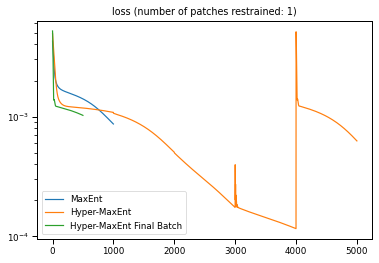

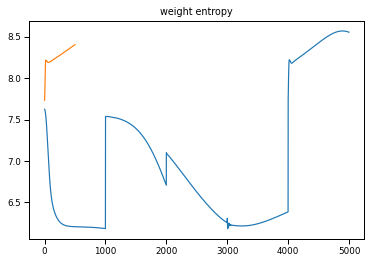

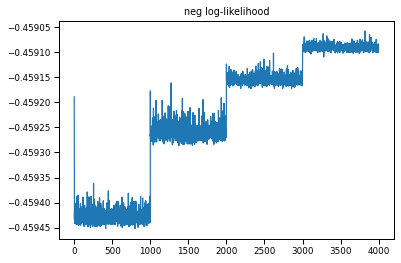

In [200]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

Text(0, 0.5, 'Population Fraction')

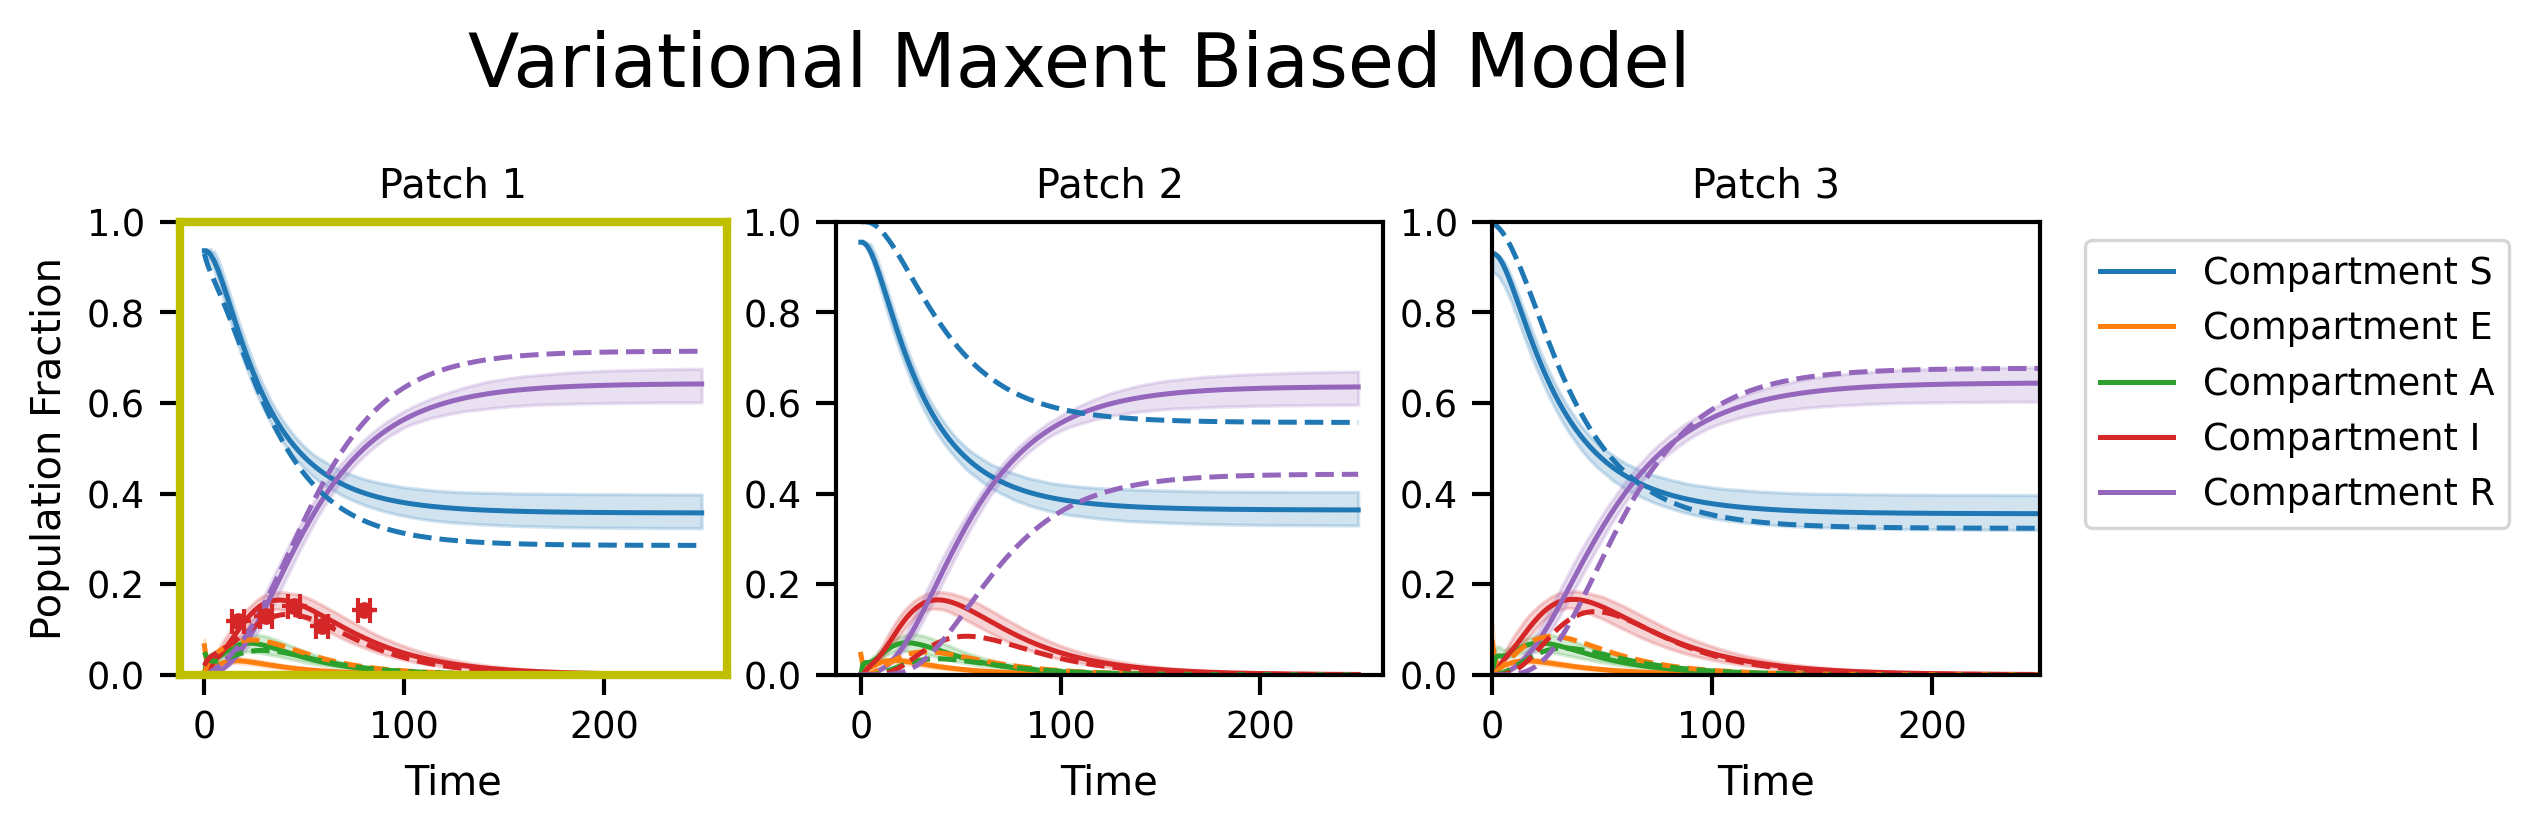

In [201]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Variational Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
# plt.savefig('varitional_maxent.svg', dpi=600)